In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

plt.rcParams["font.family"] = 'arial'
plt.rcParams['text.usetex'] = True

In [114]:
from datasets import DATASET_FULLNAMES, FEATURE_CONSTRAINTS

ALPHA = {
    'f': 0.1, 
    'c': 0.05, 
    'p': 0.1,
    'b': 0.05, 
}
BUDGET = 0.3
DELTA = 0.3

N_ALPHAS = 4
ALPHAS = {
    'f': [0.0, 0.025, 0.05, 0.075, 0.1], 
    'c': [0.0, 0.025, 0.05, 0.075, 0.1], 
    'p': [0.0, 0.025, 0.05, 0.075, 0.1], 
    'b': [0.0, 0.025, 0.05, 0.075, 0.1], 
}
DELTAS = [0.2, 0.25, 0.3, 0.35, 0.4]
BUDGETS = [0.1, 0.2, 0.3, 0.4, 0.5]

DATASETS = ['f', 'c', 'p', 'b']

In [115]:
def draw_boxplots(keys=['Accuracy', 'Recourse'], datasets=DATASETS, ensemble=False, budget=BUDGET, delta=DELTA):
    fig = plt.figure(figsize=(len(datasets)*3, len(keys)*2.0))

    for j, key in enumerate(keys):
        for i, dataset in enumerate(datasets):
            alpha = ALPHA[dataset]
            df = pd.read_csv('../res/{}_{}.csv'.format(dataset, 'forest' if ensemble else 'tree'))
            df_base = df[df.Method=='Baseline']
            df_oaf = df[df.Method=='Baseline (OAF)']
            df_tears = df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.Delta==delta)]

            methods = ['Vanilla', 'OAF', 'RACT']
            scores = [
                df_base[df_base.Budget==budget][key].values, 
                df_oaf[df_oaf.Budget==budget][key].values, 
                df_tears[df_tears.Budget==budget][key].values
            ]
            df_new = pd.melt(
                pd.DataFrame(dict([(method + '\n ({:.3})'.format(score.mean()), score) for method, score in zip(methods, scores)]))
            )

            plt.subplot(len(keys), len(datasets), i + len(datasets) * j + 1)
            sns.boxplot(x='variable', y='value', data=df_new, showfliers=False)
                
            plt.ylabel(key)
            plt.xlabel('')
            plt.title(DATASET_FULLNAMES[dataset])

    plt.tight_layout()
    
    
def to_latex(key='Accuracy', datasets=DATASETS, ensemble=False, causal=False, budget=BUDGET, delta=DELTA):
    print('\\textbf{Dataset} & \\textbf{Vanilla} & \\textbf{OAF} & \\textbf{RACT} \\\\')

    for i, dataset in enumerate(datasets):
        alpha = ALPHA[dataset]
        df = pd.read_csv('../res/{}_{}{}.csv'.format(dataset, 'forest' if ensemble else 'tree', '_causal' if causal else ''))
        df_base = df[df.Method=='Baseline']
        df_oaf = df[df.Method=='Baseline (OAF)']
        df_tears = df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.Delta==delta)]

        methods = ['Vanilla', 'OAF', 'RACT']
        scores = [
            df_base[df_base.Budget==budget][key].values, 
            df_oaf[df_oaf.Budget==budget][key].values, 
            df_tears[df_tears.Budget==budget][key].values
        ]
        
        s = '{} '.format(DATASET_FULLNAMES[dataset])
        for method, score in zip(methods, scores):
            s += '& ${} \pm {}$ '.format(score.mean().round(3), score.std().round(2))
        s += '\\\\'
        print(s)


def draw_sensitivities(keys=['Accuracy', 'Recourse'], datasets=DATASETS, ensemble=False, budget=BUDGET, errorbar=False, logscale=False):
    fig = plt.figure(figsize=(len(datasets)*3, len(keys)*3))

    for j, key in enumerate(keys):
        for i, dataset in enumerate(datasets):
            plt.subplot(len(keys), len(datasets), i + len(datasets) * j + 1)

            df = pd.read_csv('../res/{}_{}.csv'.format(dataset, 'forest' if ensemble else 'tree'))
            df_base = df[(df.Method=='Baseline') & (df.Budget==budget)]
            plt.axhline(df_base[key].values.mean(), color='tab:blue', linestyle='dashed', label='Vanilla')
            df_oaf = df[(df.Method=='Baseline (OAF)') & (df.Budget==budget)]
            plt.axhline(df_oaf[key].values.mean(), color='tab:orange', linestyle='dashed', label='OAF')

            for alpha in ALPHAS[dataset]:
                tears_mean = [df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.Budget==budget) & (df.Delta==delta)][key].values.mean() for delta in DELTAS]
                if errorbar:
                    tears_std  = [df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.Budget==budget) & (df.Delta==delta)][key].values.std() for delta in DELTAS]
                    plt.errorbar(DELTAS, tears_mean, tears_std, marker='o', markersize=5, capsize=5, label=r'RACT ($\lambda = {}$)'.format(alpha))            
                else:
                    plt.plot(DELTAS, tears_mean, marker='o', markersize=5, label=r'RACT ($\lambda = {}$)'.format(alpha))            

            plt.xlabel(r'$\delta$')
            plt.ylabel(key)
            if logscale: plt.xscale('log')
            plt.grid()
            plt.title(DATASET_FULLNAMES[dataset])

    plt.legend(loc='upper center', bbox_to_anchor=(1.75, 1.0))
    plt.tight_layout()


def draw_budget_sensitivities(alpha_i, keys=['Accuracy', 'Recourse'], datasets=DATASETS, ensemble=False, errorbar=False, logscale=False):
    fig = plt.figure(figsize=(len(datasets)*3, len(keys)*1.75))

    for j, key in enumerate(keys):
        for i, dataset in enumerate(datasets):
            alpha = ALPHAS[dataset][alpha_i]
            plt.subplot(len(keys), len(datasets), i + len(datasets) * j + 1)

            df1 = pd.read_csv('../res/{}_{}.csv'.format(dataset, 'forest' if ensemble else 'tree'))
            df2 = pd.read_csv('../res/appendix/budget/{}_{}.csv'.format(dataset, 'forest' if ensemble else 'tree'))
            df = pd.concat([df1, df2], axis=0)

            base_mean = [df[(df.Method=='Baseline') & (df.Budget==budget)][key].values.mean() for budget in BUDGETS]
            plt.plot(BUDGETS, base_mean, marker='x', markersize=5, label='Vanilla')
            oaf_mean = [df[(df.Method=='Baseline (OAF)') & (df.Budget==budget)][key].values.mean() for budget in BUDGETS]
            plt.plot(BUDGETS, oaf_mean, marker='^', markersize=5, label='OAF')

            tears_mean = [df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.Budget==budget) & (df.Delta==DELTA)][key].values.mean() for budget in BUDGETS]
            if errorbar:
                tears_std  = [df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.Budget==budget) & (df.Delta==DELTA)][key].values.std() for budget in BUDGETS]
                plt.errorbar(BUDGETS, tears_mean, tears_std, marker='o', markersize=5, capsize=5, label='RACT')
            else:
                plt.plot(BUDGETS, tears_mean, marker='o', markersize=5, label='RACT')

            plt.xlabel(r'$\varepsilon$')
            plt.ylabel(key)
            if logscale: plt.xscale('log')
            plt.grid()
            plt.title(DATASET_FULLNAMES[dataset])
            if i==0 and j==0: plt.legend()

    plt.tight_layout()


def plot_importance(dataset='g', ensemble=False, budget=BUDGET, delta=DELTA, width=0.8):
    alpha = ALPHA[dataset]
    df = pd.read_csv('../res/fi_{}_{}.csv'.format(dataset, 'forest' if ensemble else 'tree'))
    drop_keys = ['Fold', 'Method', 'Alpha', 'Budget', 'Delta']
    df_base = df[(df.Method=='Baseline') & (df.Budget==budget)].drop(drop_keys, axis=1)
    df_oaf = df[(df.Method=='Baseline (OAF)') & (df.Budget==budget)].drop(drop_keys, axis=1)
    df_tears = df[(df.Method=='TEARs') & (df.Alpha==alpha) & (df.Budget==budget) & (df.Delta==delta)].drop(drop_keys, axis=1)
    
    feature_names = [feature_name + (' (I)' if feature_constraint == 'F' else ' (M)') for feature_name, feature_constraint in zip(list(df_base.columns), FEATURE_CONSTRAINTS[dataset])]
    n_features = len(feature_names)
    fig, ax = plt.subplots()
    x = 3 * np.arange(n_features)
    
    ax.barh(x-width, df_base.mean().values, width, label='Vanilla')
    ax.barh(x, df_oaf.mean().values, width, label='OAF', tick_label=feature_names)
    ax.barh(x+width, df_tears.mean().values, width, label='RACT')
    ax.invert_yaxis()

    plt.title(DATASET_FULLNAMES[dataset])
    plt.grid(axis='x')
    plt.legend()
    plt.tight_layout()

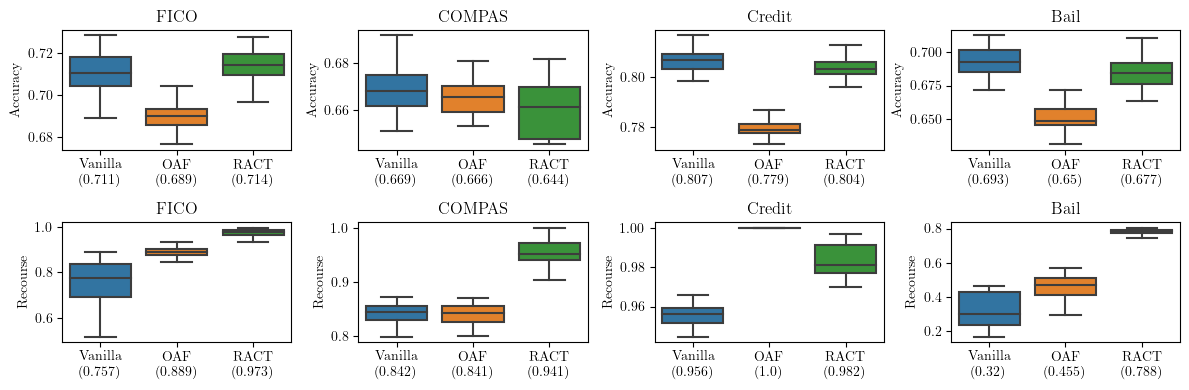

In [116]:
draw_boxplots()
plt.savefig('../fig/comparison_tree.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('../fig/comparison_tree.pdf', bbox_inches='tight', pad_inches=0.05)

In [117]:
to_latex('Time [s]')

\textbf{Dataset} & \textbf{Vanilla} & \textbf{OAF} & \textbf{RACT} \\
FICO & $0.483 \pm 0.04$ & $0.324 \pm 0.02$ & $0.429 \pm 0.06$ \\
COMPAS & $0.098 \pm 0.02$ & $0.043 \pm 0.01$ & $0.036 \pm 0.0$ \\
Credit & $1.827 \pm 0.07$ & $1.37 \pm 0.01$ & $1.587 \pm 0.1$ \\
Bail & $0.337 \pm 0.02$ & $0.054 \pm 0.01$ & $0.2 \pm 0.05$ \\


In [118]:
to_latex('Valid-Cost')

\textbf{Dataset} & \textbf{Vanilla} & \textbf{OAF} & \textbf{RACT} \\
FICO & $0.324 \pm 0.11$ & $0.174 \pm 0.02$ & $0.11 \pm 0.02$ \\
COMPAS & $0.26 \pm 0.02$ & $0.257 \pm 0.02$ & $0.184 \pm 0.05$ \\
Credit & $0.265 \pm 0.03$ & $0.001 \pm 0.0$ & $0.217 \pm 0.05$ \\
Bail & $0.6 \pm 0.09$ & $0.47 \pm 0.03$ & $0.221 \pm 0.01$ \\


In [119]:
to_latex('Plausibility')

\textbf{Dataset} & \textbf{Vanilla} & \textbf{OAF} & \textbf{RACT} \\
FICO & $0.481 \pm 0.01$ & $0.46 \pm 0.0$ & $0.476 \pm 0.0$ \\
COMPAS & $0.46 \pm 0.01$ & $0.46 \pm 0.01$ & $0.477 \pm 0.03$ \\
Credit & $0.525 \pm 0.01$ & $0.241 \pm 0.32$ & $0.506 \pm 0.01$ \\
Bail & $0.511 \pm 0.01$ & $0.506 \pm 0.01$ & $0.517 \pm 0.01$ \\


In [120]:
to_latex('Budget-Validity', causal=True)

\textbf{Dataset} & \textbf{Vanilla} & \textbf{OAF} & \textbf{RACT} \\
FICO & $0.554 \pm 0.15$ & $0.799 \pm 0.05$ & $0.944 \pm 0.04$ \\
COMPAS & $0.602 \pm 0.04$ & $0.611 \pm 0.04$ & $0.838 \pm 0.14$ \\
Credit & $0.531 \pm 0.05$ & $1.0 \pm 0.0$ & $0.672 \pm 0.1$ \\
Bail & $0.17 \pm 0.1$ & $0.37 \pm 0.07$ & $0.726 \pm 0.02$ \\


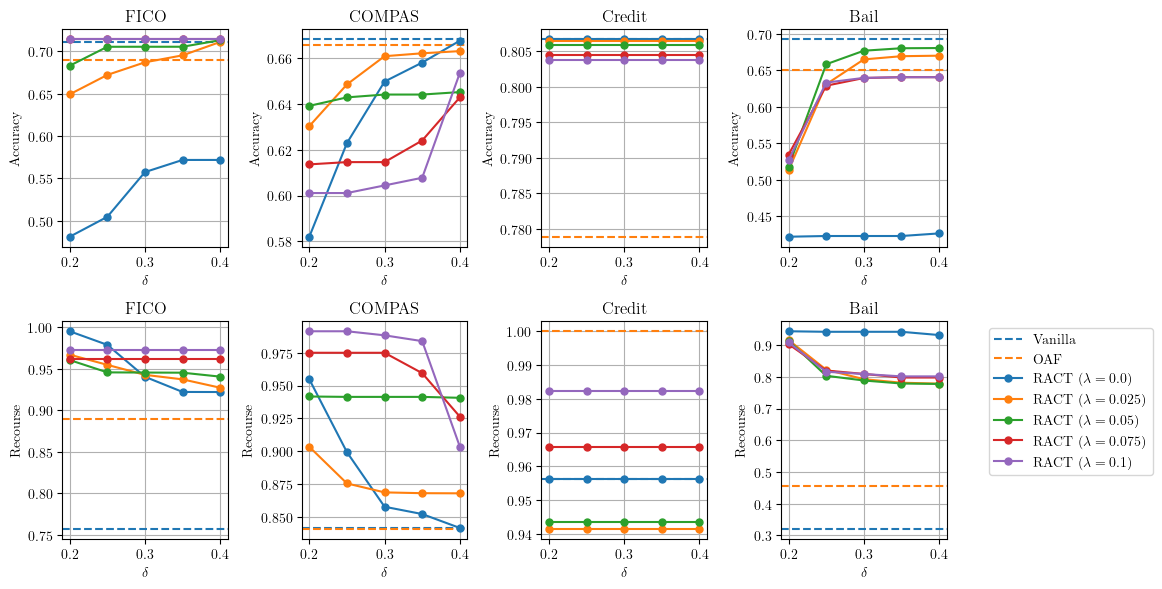

In [121]:
draw_sensitivities()
plt.savefig('../fig/appendix/tradeoff_tree.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('../fig/appendix/tradeoff_tree.pdf', bbox_inches='tight', pad_inches=0.05)

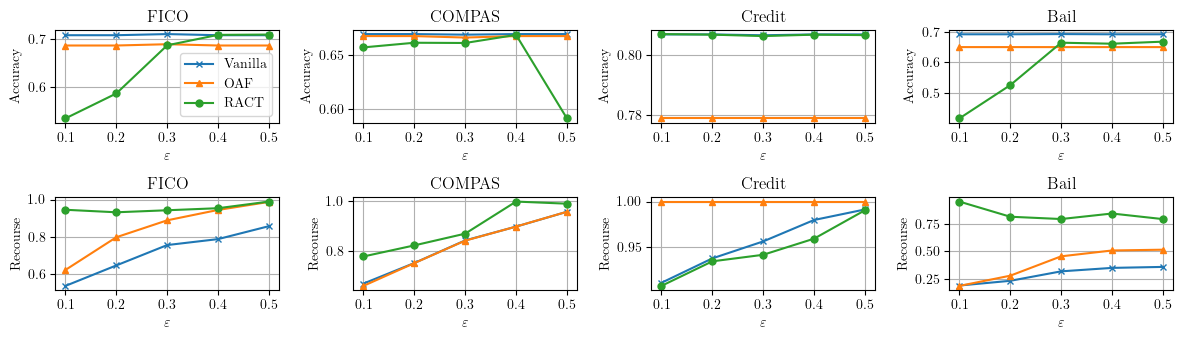

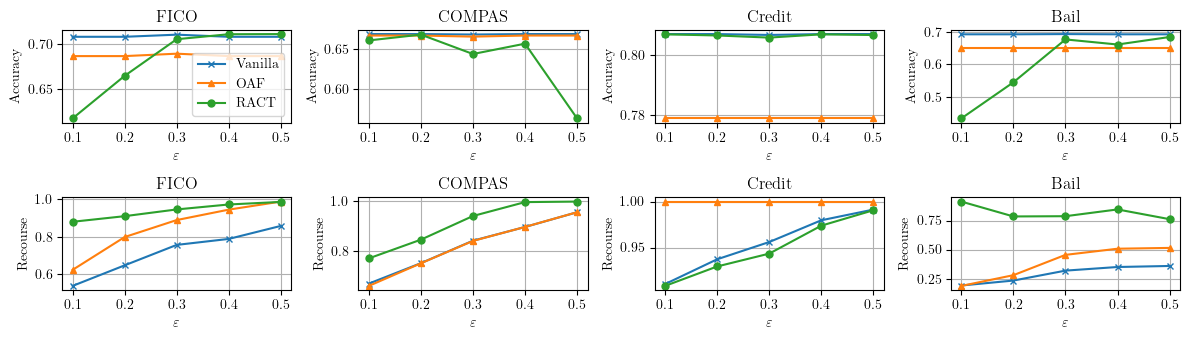

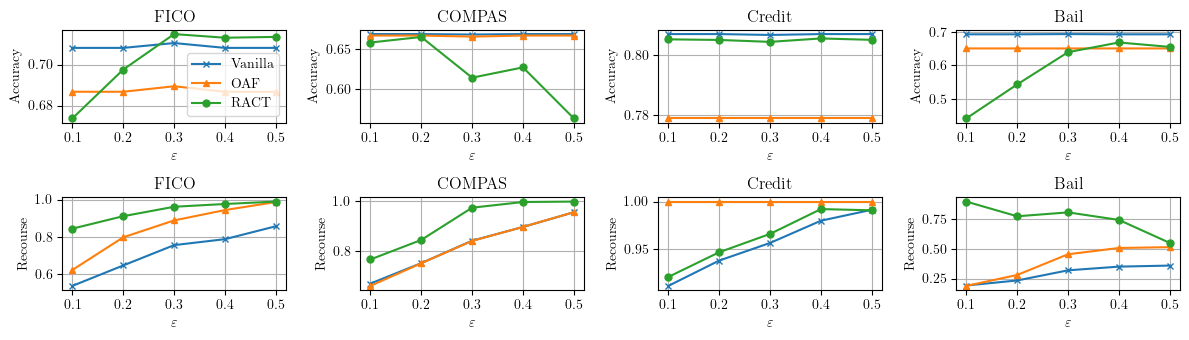

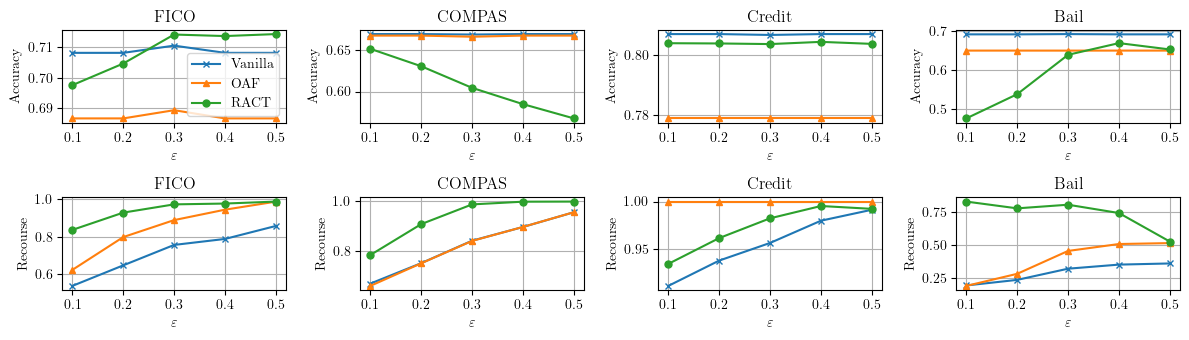

In [123]:
for i in range(1, N_ALPHAS+1):
    draw_budget_sensitivities(i)
    plt.savefig('../fig/appendix/sensitivity_tree_{}.png'.format(i), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('../fig/appendix/sensitivity_tree_{}.pdf'.format(i), bbox_inches='tight', pad_inches=0.05)
